# Regularization

Otro ejemplo de regularización

In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import scipy.io


%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head.

<img src="images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>


They give you the following 2D dataset from France's past 10 games.

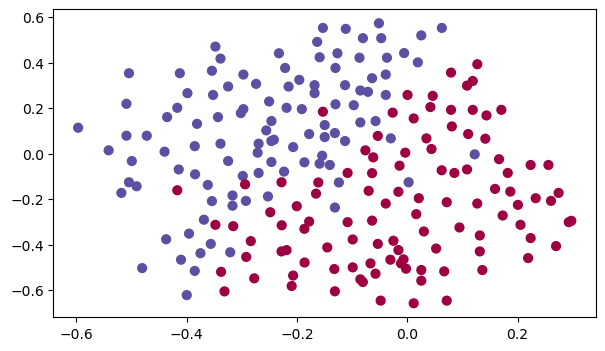

In [5]:

data = scipy.io.loadmat('./datasets/data.mat')
train_X = data['X']
train_Y = data['y']
test_X = data['Xval']
test_Y = data['yval']

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well.

You will first try a non-regularized model. Then you'll learn how to regularize it and decide which model you will choose to solve the French Football Corporation's problem.

## 1 - Modelo sin regularizacion

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Crear el modelo
model = Sequential()
model.add(Input(shape=(train_X.shape[1],)))
# Añadir la primera capa oculta con 20 neuronas y función de activación ReLU
model.add(Dense(1000, activation='relu'))

# Añadir la segunda capa oculta con 3 neuronas y función de activación ReLU
model.add(Dense(1000, activation='relu'))

# Añadir la capa de salida con 1 neurona y función de activación sigmoide
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])


# Entrenar el modelo
historia=model.fit(train_X, train_Y, epochs=1000, batch_size=32,validation_data=(test_X, test_Y),verbose=0)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(train_X, train_Y)
print(f'Accuracy Train: {accuracy}')

loss, accuracy = model.evaluate(test_X, test_Y)
print(f'Accuracy Test: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0113
Accuracy Train: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9213 - loss: 0.7397
Accuracy Test: 0.9150000214576721


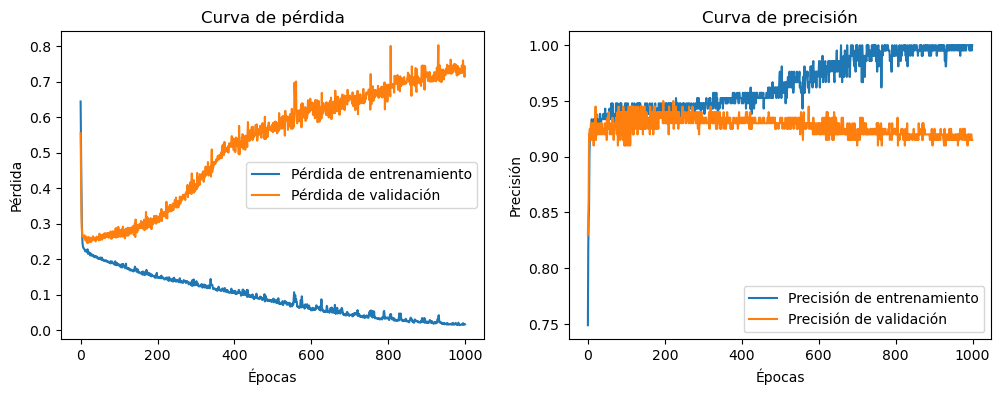

In [10]:
# Dibujar las curvas de entrenamiento y validación para la pérdida y la precisión
plt.figure(figsize=(12, 4))

# Curva de pérdida
plt.subplot(1, 2, 1)
plt.plot(historia.history['loss'], label='Pérdida de entrenamiento')
plt.plot(historia.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Curva de precisión
plt.subplot(1, 2, 2)
plt.plot(historia.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(historia.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

Vamos a dibujar el dataset y la frontera de decisión

2937/2937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


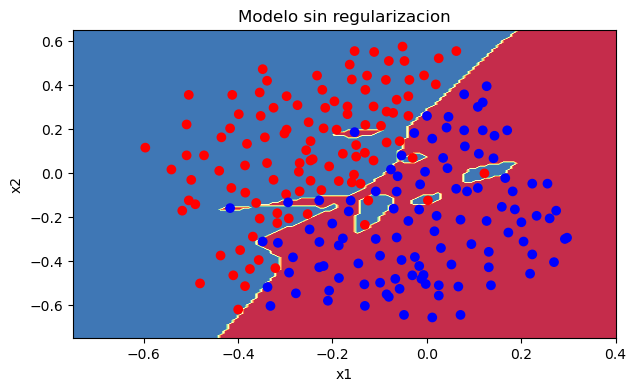

In [11]:
plt.title("Modelo sin regularizacion")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
x_min, x_max = train_X[:, 0].min() - 1, train_X[:, 0].max() + 1
y_min, y_max = train_X[:, 1].min() - 1, train_X[:, 1].max() + 1
h = 0.01
# Generamos un grid de puntos con separación h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predicciones para cada punto en el grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
# Dibujamos el contorno y los puntos originales
plt.contourf(xx, yy, Z,cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, cmap=plt.cm.bwr)
plt.show()

Es muy evidente que está haciendo overtiffing, está siguiendo hasta el ruido del dataset.

## 2 - L2 Regularizacion

La manera standard de reducir el overfitting es la **regularizacion L2**. Consiste en modificar la función de coste de:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
A:
$$J_{regularizada} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{coste de regularizacion} \tag{2}$$


In [13]:
from keras.regularizers import l2

# Crear el modelo con regularización L2
model_l2 = Sequential()
model_l2.add(Input(shape=(train_X.shape[1],)))
# Añadir la primera capa oculta con 20 neuronas, función de activación ReLU y regularización L2
model_l2.add(Dense(1000, input_dim=train_X.shape[1], activation='relu', kernel_regularizer=l2(0.001)))

# Añadir la segunda capa oculta con 3 neuronas, función de activación ReLU y regularización L2
model_l2.add(Dense(1000, activation='relu', kernel_regularizer=l2(0.001)))

# Añadir la capa de salida con 1 neurona, función de activación sigmoide y regularización L2
model_l2.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_l2.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
historia_l2 = model_l2.fit(train_X, train_Y, epochs=1000, batch_size=32, validation_data=(test_X, test_Y), verbose=0)

# Evaluar el modelo en el conjunto de prueba
loss_l2, accuracy_l2 = model_l2.evaluate(train_X, train_Y)
print(f'Accuracy Train: {accuracy_l2}')

loss_l2, accuracy_l2 = model_l2.evaluate(test_X, test_Y)
print(f'Accuracy Test: {accuracy_l2}')

c:\Users\igome\anaconda3\envs\deepl\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9506 - loss: 0.1719
Accuracy Train: 0.9478672742843628
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9393 - loss: 0.2926
Accuracy Test: 0.9350000023841858


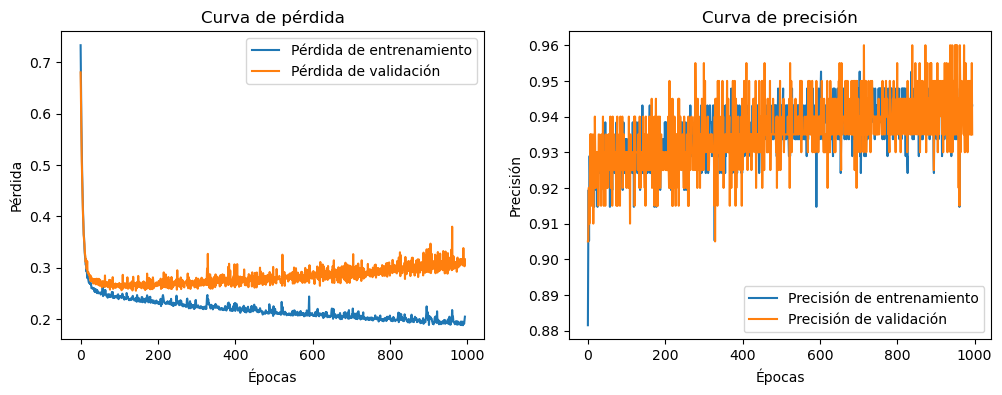

In [14]:
# Dibujar las curvas de entrenamiento y validación para la pérdida y la precisión
plt.figure(figsize=(12, 4))

# Curva de pérdida
plt.subplot(1, 2, 1)
plt.plot(historia_l2.history['loss'][5:], label='Pérdida de entrenamiento')
plt.plot(historia_l2.history['val_loss'][5:], label='Pérdida de validación')
plt.title('Curva de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Curva de precisión
plt.subplot(1, 2, 2)
plt.plot(historia_l2.history['accuracy'][5:], label='Precisión de entrenamiento')
plt.plot(historia_l2.history['val_accuracy'][5:], label='Precisión de validación')
plt.title('Curva de precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

Fantastico, hemos salvado a la selección francesa de fútbol.

Dibujemos la frontera de decisión

   5/2937 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step

2937/2937 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step


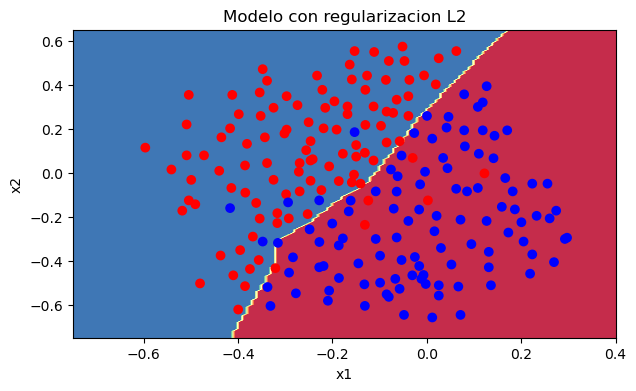

In [15]:
plt.title("Modelo con regularizacion L2")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
x_min, x_max = train_X[:, 0].min() - 1, train_X[:, 0].max() + 1
y_min, y_max = train_X[:, 1].min() - 1, train_X[:, 1].max() + 1
h = 0.01
# Generamos un grid de puntos con separación h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predicciones para cada punto en el grid
Z = model_l2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
# Dibujamos el contorno y los puntos originales
plt.contourf(xx, yy, Z,cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, cmap=plt.cm.bwr)
plt.show()

**Observaciones**:
- El valor de $\lambda$ is un parámetro que hay que ajustar.
- Si $\lambda$ es demasiado grande podemos producir "underfitting".

**What is L2-regularization actually doing?**:

Implicaciones de la regularización:
- Calculo del coste:
    - Se añade un termino adicional a la función de coste
    - En el calculo de la propagación hacia atras, se añade un término adicional al gradiente
- Al final del proceso de optimización, los pesos son más pequeños  ("weight decay").

## 3 - Dropout

Finalmente, el dropout es una técnica de regularización ampliamente utilizada que es específica del aprendizaje profundo.
Apaga aleatoriamente algunas neuronas en cada iteración. ¡Mira estos dos videos para entender qué significa esto!

<!-- Para comprender el dropout, considera esta conversación con un amigo: - Amigo: "¿Por qué necesitas todas estas neuronas para entrenar tu red y clasificar imágenes?". - Tú: "Porque cada neurona contiene un peso y puede aprender características/detalles/formas específicas de una imagen. ¡Cuantas más neuronas tenga, más características aprenderá mi modelo!" - Amigo: "Entiendo, pero ¿estás seguro de que tus neuronas están aprendiendo diferentes características y no todas las mismas?" - Tú: "Buen punto... Las neuronas en la misma capa en realidad no se comunican entre sí. Definitivamente podría ser posible que aprendan las mismas características/formas/detalles de la imagen... lo cual sería redundante. Debería haber una solución." !-->


<center>
<video width="620" height="440" src="images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Figura 2 </u>: Drop-out en la segunda capa oculta.</center>
En cada iteración, apagas (= pones a cero) cada neurona de una capa con una probabilidad de 1 - keep_prob  o la mantienes con una probabilidad de keep_prob (50% aqui). Las neuronas apagadas no contribuyen al entrenamiento, ni en la propagación hacia adelante ni en la propagación hacia atrás de la iteración. </center></caption>

<center>
<video width="620" height="440" src="images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Figure 3 </u>: Drop-out en la primera y tercera capas</center>


Cuando apagas algunas neuronas, en realidad estás modificando tu modelo. La idea detrás del dropout es que, en cada iteración, entrenas un modelo diferente que utiliza solo un subconjunto de tus neuronas. Con el dropout, tus neuronas se vuelven menos sensibles a la activación de otra neurona específica, porque esa otra neurona podría ser apagada en cualquier momento.

In [16]:
from keras.layers import Dropout, Input

# Crear el modelo con regularización dropout
model_drop = Sequential()
model_drop.add(Input(shape=(2,)))
model_drop.add(Dense(1000, activation='relu'))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(1000, activation='relu'))
model_drop.add(Dropout(0.5))
model_drop.add(Dense(1, activation='sigmoid'))


# Compilar el modelo
model_drop.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
historia_l2 = model_drop.fit(train_X, train_Y, epochs=1000, batch_size=32, validation_data=(test_X, test_Y), verbose=0)

# Evaluar el modelo en el conjunto de prueba
loss_drop, accuracy_drop = model_drop.evaluate(train_X, train_Y)
print(f'Accuracy Train: {accuracy_drop}')

loss_drop, accuracy_drop = model_drop.evaluate(test_X, test_Y)
print(f'Accuracy Test: {accuracy_drop}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9711 - loss: 0.0663
Accuracy Train: 0.9620853066444397
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9508 - loss: 0.5501
Accuracy Test: 0.9449999928474426


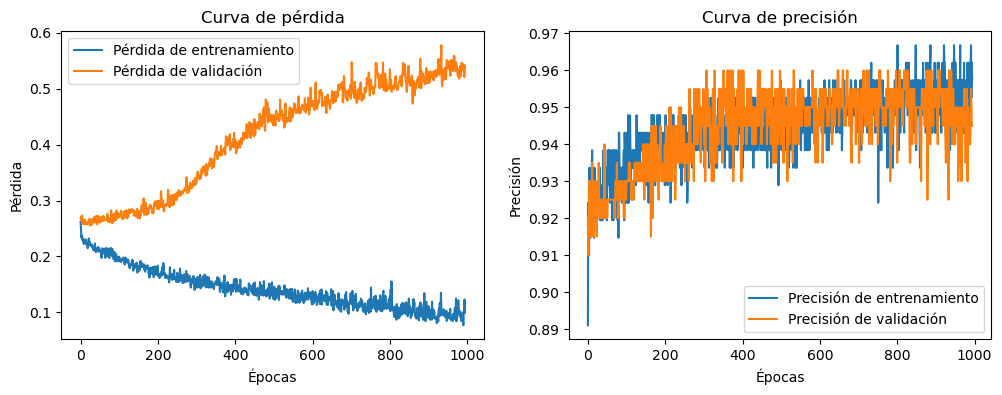

In [17]:
# Dibujar las curvas de entrenamiento y validación para la pérdida y la precisión
plt.figure(figsize=(12, 4))

# Curva de pérdida
plt.subplot(1, 2, 1)
plt.plot(historia_l2.history['loss'][5:], label='Pérdida de entrenamiento')
plt.plot(historia_l2.history['val_loss'][5:], label='Pérdida de validación')
plt.title('Curva de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Curva de precisión
plt.subplot(1, 2, 2)
plt.plot(historia_l2.history['accuracy'][5:], label='Precisión de entrenamiento')
plt.plot(historia_l2.history['val_accuracy'][5:], label='Precisión de validación')
plt.title('Curva de precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

Dropout works great! The test accuracy has increased again (to 95%)! Your model is not overfitting the training set and does a great job on the test set. The French football team will be forever grateful to you!

Run the code below to plot the decision boundary.

2937/2937 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step


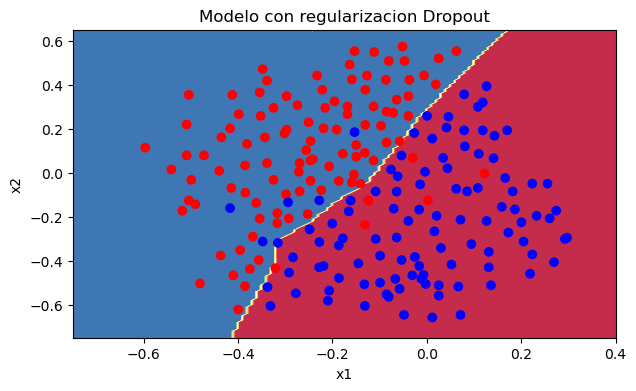

In [18]:
plt.title("Modelo con regularizacion Dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
x_min, x_max = train_X[:, 0].min() - 1, train_X[:, 0].max() + 1
y_min, y_max = train_X[:, 1].min() - 1, train_X[:, 1].max() + 1
h = 0.01
# Generamos un grid de puntos con separación h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predicciones para cada punto en el grid
Z = model_l2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
# Dibujamos el contorno y los puntos originales
plt.contourf(xx, yy, Z,cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, cmap=plt.cm.bwr)
plt.show()

In [24]:

from keras.layers import Dropout, Input, BatchNormalization

# Crear el modelo con regularización dropout
model_drop = Sequential()
model_drop.add(Input(shape=(2,)))
model_drop.add(Dense(1000, activation='relu'))
model_drop.add(BatchNormalization())
model_drop.add(Dense(1000, activation='relu'))
model_drop.add(BatchNormalization())
model_drop.add(Dense(1, activation='sigmoid'))

model_drop.add(Dropout(0.5))

# Compilar el modelo
model_drop.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
historia_l2 = model_drop.fit(train_X, train_Y, epochs=1000, batch_size=32, validation_data=(test_X, test_Y), verbose=0)

# Evaluar el modelo en el conjunto de prueba
loss_drop, accuracy_drop = model_drop.evaluate(train_X, train_Y)
print(f'Accuracy Train: {accuracy_drop}')

loss_drop, accuracy_drop = model_drop.evaluate(test_X, test_Y)
print(f'Accuracy Test: {accuracy_drop}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8905 - loss: 0.2190
Accuracy Train: 0.8672986030578613
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9048 - loss: 0.2748
Accuracy Test: 0.8849999904632568
